# Computing probabilistic numbers of PTA binaries from 2MASS, and making realizations of GW skies 

### Chiara Mingarelli, mingarelli@gmail.com

In [2]:
#!/usr/bin/env python
"""step1_make_GW_skies.ipynb: a notebook to create gravitational-wave skies """

__author__ = "Chiara M. F. Mingarelli"
__copyright__ = "Copyright 2017, GWASAP project"
__credits__ = ["Chiara Mingarelli"]
__license__ = "GPL"
__version__ = "0.0.1"
__maintainer__ = "Chiara Mingarelli"
__email__ = "mingarelli@gmail.com"

In [4]:
from __future__ import division
from IPython.display import display, Math, Latex
import math
from math import sqrt, cos, sin, pi
import numpy as np
#import statsmodels.api as sm
from scipy.interpolate import interp1d
from scipy.integrate import quad
from scipy.stats import norm
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import matplotlib.mlab as ml
from matplotlib.ticker import FormatStrFormatter, LinearLocator, NullFormatter, NullLocator, MultipleLocator
import matplotlib.ticker
import matplotlib.colors
from matplotlib.font_manager import FontProperties
from matplotlib import rc, text
#import healpy as hp
#import plot
import astropy
import astropy.units as u
from astropy.cosmology import Planck15, z_at_value
import time
import collections

%matplotlib inline
%config InlineBackend.figure_format = "retina"

In [5]:
def stall(Mstar):
    Mstar = np.log10(Mstar)
    MBH = 1.456*Mstar - 8.908
    return 10**MBH

In [6]:
stall(1e11)

12823305.826560179

## constants and shortcuts 

In [7]:
# physical constants for natural units c = G = 1
c=2.99792458*(10**8)
G=6.67428*(10**(-11))
s_mass=G*(1.98892*10**(30))/(c**3)

# common function shortcuts
log10 = np.log10
pi = np.pi
sqrt = np.sqrt

In [62]:
# Mass functions

def mu(m1,m2): return s_mass*(m1*m2)/(m1+m2) # reduced mass

def M(m1,m2):  return s_mass*(m1+m2) # total mass

def mchirp(m1,m2): return ((mu(m1,m2))**(3./5))*((M(m1,m2))**(2./5))  # chirp mass

def mchirp_q(q,Mtot): 
    """
    chirp mass in terms of q and M_tot. Answer in seconds.
    """
    ans = (q/(1+q)**2)**(3/5)*Mtot*s_mass
    return ans

def parsec2sec(d): return d*3.08568025e16/299792458


# Functions related to galaxy catalogue 

def Mk2mStar(mag):
    """
    converting from k-band luminosity to M* using Eq.2 from Ma et al. (2014)
    valid for early-type galaxies
    """
    Mstar = 10.58-0.44*(mag + 23)
    return 10**(Mstar)

def Mbh2Mbulge(Mbulge):
    """
    M_BH-M_bulge. Bulge mass to black hole mass (note that M_bulge = Mstar; assume these are the same)
    McConnell and Ma (2013) relation below Figure 3
    Includes scatter in the relation, \epsilon = 0.34
    Answer in solar masses.
    """
    exponent = 8.46+1.05*log10(Mbulge/1e11)
    ans_w_scatter = np.random.normal(exponent,0.34)
    #print locals()
    return 10**ans_w_scatter

def Mbh2Mbulge_noScat(Mbulge):
    """
    M_BH-M_bulge. Bulge mass to black hole mass (note that M_bulge = Mstar; assume these are the same)
    McConnell and Ma (2013) relation below Figure 3
    Includes scatter in the relation, \epsilon = 0.34
    Answer in solar masses.
    """
    exponent = 8.46+1.05*log10(Mbulge/1e11)
    #ans_w_scatter = np.random.normal(exponent,0.34)
    #print locals()
    return 10**exponent

# For GWs: strain, GW frequency and time to coalescence 

def strain(mass, dist, freq):
    """
    Eq. 4 from Schutz and Ma, strain for an equal mass binary
    mass in solar masses, freq in Hz, distance in Mpc
    I think this is off by a factor of 2**(-1/3)
    """
    ans = 6.9e-15*(mass/1e9)**(5/3)*(10/dist)*(freq/1e-8)**(2/3)
    return ans

def generic_strain(q_mass_ratio, Mtot, dist, freq):
    strain = sqrt(32./5)*mchirp_q(q_mass_ratio,Mtot)**(5/3)*(pi*freq)**(2/3)/parsec2sec(dist*1e6)
    return strain

def generic_strain_wMc(chirp_mass, dist, freq):
    strain = sqrt(32./5)*(chirp_mass*s_mass)**(5/3)*(pi*freq)**(2/3)/parsec2sec(dist*1e6)
    return strain

def freq_gw(q, Mtot, tc):
    """
    GW frquency as a function of time to coalescence in years, total mass and mass ratio
    Result from integration of standard df/dt for GWs
    """
    ans = mchirp_q(q,Mtot)**(-5/8)/pi*(256/5*tc*31556926)**(-3/8)
    return ans

def freq_gw_wMc(chirp_mass, tc):
    """
    GW frquency as a function of time to coalescence in years and chirp mass (directly)
    Result from integration of standard df/dt for GWs
    """
    ans = (chirp_mass*s_mass)**(-5/8)/pi*(256/5*tc*31556926)**(-3/8)
    return ans

def time_to_c(q, Mtot, freq):
    """
    time to coalescence of a binary in years
    """
    ans = (pi*freq)**(-8/3)*mchirp_q(q,Mtot)**(-5/3)*5/256
    return (ans/31556926)

def time_to_c_wMc(chirp_mass, freq):
    """
    freq. in Hz, input chirp mass in solar masses, answer in years
    """
    ans = (pi*freq)**(-8/3)*(chirp_mass*s_mass)**(-5/3)*5/256
    return (ans/31556926)

def ecc_integral(e):
    return e**(29/19)*(1+(121./304)*e**2)**(1181/2299)/(1-e**2)**1.5

def time_to_c_ecc(e0,q,Mtot,orb_freq):
    """
    time to coalescence for the eccentric case, from Peters (1964)
    eqns. 5.11, 5.14. This is done via numerical integration and 
    needs initial conditions (a0,e0)
    """
    a0 = (Mtot*s_mass/(2*pi*orb_freq)**2)**(1./3)
    c0 = a0*(1-e0**2)/e0**(12/19)/(1+121./304*e0**2)**(870/2299)
    m1 = Mtot*s_mass/(1+q)
    m2 = q*m1
    beta = 64/5*m1*m2*Mtot*s_mass
    ans = 12/19*(c0**4/beta)*quad(ecc_integral,0,e0)[0]
    return ans/31556926

def time_to_c_ecc_approx(e0,q,Mtot,orb_freq):
    a0 = (Mtot*s_mass/(2*pi*orb_freq)**2)**(1./3)
    c0 = a0*(1-e0**2)/e0**(12/19)/(1+121./304*e0**2)**(870/2299)
    m1 = Mtot*s_mass/(1+q)
    m2 = q*m1
    beta = 64/5*m1*m2*Mtot*s_mass
    return c0**4/(4*beta)*e0**(48/19)/31556926
    
def i_prob(q, Mtot, min_freq, total_T):
    """
    input time in years, Mtot in solar masses
    """
    ans = time_to_c(q, Mtot, min_freq)/total_T
    return ans

def i_prob_wMc(chirpMass, min_freq, total_T):
    """
    input time in years, Mtot in solar masses
    Probability that this galaxy contains a binary in the PTA band
    """
    ans = time_to_c_wMc(chirpMass, min_freq)/total_T
    return ans


In [63]:
time_to_c_ecc(1e-100,1,10**8,0.5e-9),time_to_c(1,10**8,1e-9)

(3805072726.595043, 3805072748.74217)

In [64]:
'%.2e'%Mk2mStar(-25)

'2.88e+11'

## Hardening and Dynamical Friction Timescales

In [100]:
# Black hole merger timescales from galaxy merger timescale; Binney and Tremaine 1987 
# "Galactic Dynamics"; also Sesana and Khan 2015
# "a" is computed by equating R_eff from Dabringhausen, Hilker & Kroupa (2008) Eq. 4 and 

def R_eff(Mstar):
    """
    Effective radius, Dabringhausen, Hilker & Kroupa (2008) Eq. 4
    Answer in units of parsecs (pc)
    """
    ans = np.maximum(2.95*(Mstar/1e6)**0.596,34.8*(Mstar/1e6)**0.399)
    return ans

def r0_sol(Mstar, gamma):
    """
    r0 solution obtained by equating XX with YY (as in Sesana & Khan 2015)
    answer in parsecs
    """
    ans = R_eff(Mstar)/0.75*(2**(1/(3-gamma))-1)
    return ans

def sigmaVel(Mstar):
    """
    from Zahid et al. 2016 Eq 5 and Table 1 fits; assume massive galaxies with Mb > 10.3
    answer in km/s
    """
    logSigmaB = 2.2969
    alpha2 = 0.299
    Mb = 10**(11) #solar masses
    logAns = logSigmaB + alpha2*log10(Mstar/Mb)
    #print "sigmaVel is ", (10**logAns)
    return 10**logAns

def tfric(Mstar,M2):
    """
    Final eq from https://webhome.weizmann.ac.il/home/iair/astrocourse/tutorial8.pdf
    returns timescale in Gyr
    Mbh should be mass of primary
    """
    # assume log(Lambda) = 10
    vc = sqrt(2)*sigmaVel(Mstar)
    #a = semiMaj_a(Mstar)/1e3 # make sure "a" units are kpc
    a = R_eff(Mstar)/1e3
    ans = 2.64e10*(a/2)**2*(vc/250)*(1e6/M2)
    return ans/1e9 

def rho_r(Mstar, gamma, r_var):
    """
    gamma for Dehen profiles; Sesana & Khan 2015, Eq. 1 
    r_const = r_0 or "a" in Dehen 1993
    r_var = "r" in Dehen 1993
    answer in seconds^-2
    """
    r_const = parsec2sec(r0_sol(Mstar, gamma)) # parsec to seconds
    r_var = parsec2sec(r_var)
    num = (3-gamma)*(Mstar*s_mass)*r_const
    deno = 4*pi*(r_var)**gamma*(r_var+r_const)**(4-gamma)
    ans = num/deno
    return ans

def r_inf(Mstar,gamma,Mtot):
    """
    influence radius, r_inf, from Sesana & Khan 2015
    answer in parsecs
    """
    num = r0_sol(Mstar, gamma)
    deno = (Mstar/(2*Mtot))**(1/(3-gamma))-1 #units of solar masses cancel out
    rinf = num/deno
    return rinf

def a_StarGW(Mstar,q,Mtot,gamma,H):
    """
    Eq. 6, Sesana & Khan 2015. Assume no eccentricity, e=0.
    Answer in seconds
    """
    sigmaInf = sigmaVel(Mstar)*1000/c # km/s converted to m/s then /c for dimensionless units
    rho_inf = rho_r(Mstar, gamma, r_inf(Mstar,gamma,Mtot)) #rinf in pc, rho_inf func converts
    num = 64*sigmaInf*(q*(Mtot*s_mass)**3/(1+q)**2)
    deno = 5*H*rho_inf
    ans = (num/deno)**(1/5)
    return ans

def a_StarGW_ecc(Mstar,q,Mtot,gamma,H,e):
    """
    Eq. 6, Sesana & Khan 2015.
    Answer in seconds
    """
    sigmaInf = sigmaVel(Mstar)*1000/c # km/s converted to m/s then /c for dimensionless units
    rho_inf = rho_r(Mstar, gamma, r_inf(Mstar,gamma,Mtot)) #rinf in pc, rho_inf func converts
    F_e = (1-e**2)**(-7./2)*(1+(73./24)*e**2 + (37./96)*e**4)
    num = 64*sigmaInf*(q*(Mtot*s_mass)**3/(1+q)**2*F_e)
    deno = 5*H*rho_inf
    ans = (num/deno)**(1/5)
    return ans

def t_hard(Mstar,q,gamma,Mtot):
    """
    Hardening timescale with stars, Eq. 7 Sesana & Khan 2015
    Answer in Gyrs
    """
    a_val = parsec2sec(r0_sol(Mstar, gamma))
    H = 15
    aStarGW = a_StarGW(Mstar,q,Mtot,gamma,H) #check units
    sigma_inf = sigmaVel(Mstar)*1000/c
    rinf_val = r_inf(Mstar,gamma,Mtot)
    rho_inf = rho_r(Mstar, gamma, rinf_val)
    ans = sigma_inf/(H*rho_inf*aStarGW)
    return ans/31536000/1e9, rinf_val

def t_hard_ecc(Mstar,q,gamma,Mtot,e):
    """
    Hardening timescale with stars, Eq. 7 Sesana & Khan 2015
    Answer in Gyrs
    """
    a_val = parsec2sec(r0_sol(Mstar, gamma))
    H = 15
    aStarGW_ecc = a_StarGW_ecc(Mstar,q,Mtot,gamma,H,e) #check units
    sigma_inf = sigmaVel(Mstar)*1000/c
    rinf_val = r_inf(Mstar,gamma,Mtot)
    rho_inf = rho_r(Mstar, gamma, rinf_val)
    ans = sigma_inf/(H*rho_inf*aStarGW_ecc)
    return ans/31536000/1e9, rinf_val

## Parameters and functions for Illustris

In [66]:
# constants for Illustris, Table 1 of Rodriguez-Gomez et al. (2016), assuming z = 0. 

M0 = 2e11 # solar masses
A0 = 10**(-2.2287) # Gyr^-1
alpha0 = 0.2241
alpha1 = -1.1759
delta0 = 0.7668
beta0 = -1.2595
beta1 = 0.0611
gamma = -0.0477
eta = 2.4644
delta0 = 0.7668
delta1 = -0.4695

In [101]:
# For Illustris galaxy-galaxy merger rate
# functions for Illustris, Table 1 of Rodriguez-Gomez et al. (2016). 

def A_z(z): return A0*(1+z)**eta 
def alpha(z): return alpha0*(1+z)**alpha1
def beta(z): return beta0*(1+z)**beta1
def delta(z): return delta0*(1+z)**delta1

def MzMnow(mu, sigma):
    """
    Scale the value of M* to its value at z=0.3.
    This is from de Lucia and Blaizot 2007, Figure 7.
    """
    ans = np.random.normal(mu, sigma)
    return ans

def illus_merg(mustar, Mstar,z):
    """
    Galaxy-galaxy merger rate from Illustris simulation.
    This is d^2N_mergers/dmu dt (M, mu*), in units of Gyr^-1
    Table 1 of Rodriguez-Gomez et al. (2016).
    """
    exponent = beta(z) + gamma*np.log10(Mstar/1e10)
    rate = A_z(z)*(Mstar/1e10)**alpha(z)*(1+(Mstar/M0)**delta(z))*mustar**exponent
    return rate

def cumulative_merg_ill(mu_min, mu_max, Mstar, z):
    """
    Cumulative merger probability over a range of mu^*. 
    For major mergers, this is 0.25 to 1.0
    """
    ans, err = quad(illus_merg, mu_min, mu_max, args = (Mstar,z))
    return ans

def i_prob_Illustris(Mstar, Mtot, q, e0, min_freq):
    """
    Probability that this galaxy contains a binary in the PTA band
    """
    chirpMass = mchirp_q(q,Mtot)/s_mass #in solar mass units
    M1 = Mtot/(1+q)
    M2 = M1*q
    mu_min, mu_max = 0.25, 1.0
    gamma = 1.0 # for Hernquist profile, see Dehen 1993
    
    #Mstar = Mstar*MzMnow(mu, sigma) # scale M* according to Figure 7 of de Lucia and Blaizot 2007
    MstarZ = 0.7*Mstar
    hardening_t, r_inf_here = t_hard_ecc(MstarZ,q,gamma,Mtot,e0)
    friction_t = tfric(MstarZ,M2)
    timescale = hardening_t + friction_t  # Gyrs 

    # if timescale > 12.25 Gyrs (z=4), no merging SMBHs
    # also limit of validity for Rodriguez-Gomez + (2015) fit in Table 1.
    if timescale > 12.25: 
        return 0, 'nan', timescale*1e9, 'nan', 'nan',  r_inf_here, friction_t, hardening_t
    else:
        z = z_at_value(Planck15.age, (13.79-timescale) * u.Gyr) # redshift of progenitor galaxies
        t2c = time_to_c(q,Mtot,min_freq) # in years
        mergRate = cumulative_merg_ill(mu_min, mu_max, MstarZ, z) # rate per Gigayear
        Tz = timescale*1e9
        ans = t2c*mergRate/1e9
        return ans, z, Tz, mergRate, t2c, r_inf_here, friction_t, hardening_t

In [69]:
# Major Merger, mu = 0.25, 1
mu_min = 0.25
mu_max = 1.0

lst03L = []
lst1L = []
lst2L = []
bh_rangeL = range(10**7,10**9,5*10**6) #LISA
for j in bh_rangeL:   
    lst03L.append(cumulative_merg_ill(mu_min, mu_max,j, z=0.3))
    lst1L.append(cumulative_merg_ill(mu_min, mu_max,j, z=1))
    lst2L.append(cumulative_merg_ill(mu_min, mu_max,j, z=2))

In [70]:
bh_rangePTA = range(10**9,10**13,10**8) #PTA
lst03 = []
lst1 = []
lst2 = []

for j in bh_rangePTA:   
    lst03.append(cumulative_merg_ill(mu_min, mu_max,j, z=0.3))
    lst1.append(cumulative_merg_ill(mu_min, mu_max,j, z=1))
    lst2.append(cumulative_merg_ill(mu_min, mu_max,j, z=2))

In [13]:
'%.2e'%Mbh2Mbulge(1e13) # 1e11 - 1e13 M_sun for PTA

'4.62e+10'

In [14]:

'%.2e'%Mbh2Mbulge(1e7) # 1e7 - 1e9 M_sun for LISA

'4.19e+04'

In [15]:
fig_width_pt = 245.27 #513.17           # Get this from LaTeX using \showthe\columnwidth
inches_per_pt = 1.0/72.27               # Convert pt to inches
golden_mean = (np.sqrt(5)-1.0)/2.0      # Aesthetic ratio
fig_width = fig_width_pt*inches_per_pt  # width in inches
fig_height =fig_width*golden_mean       # height in inches
fig_size = [fig_width,fig_height]

params = {'backend': 'pdf',
        'axes.labelsize': 7,
        'lines.markersize': 4,
        'font.size': 7,
        'xtick.major.size':6,
        'xtick.minor.size':3,  
        'ytick.major.size':6,
        'ytick.minor.size':3, 
        'xtick.major.width':0.5,
        'ytick.major.width':0.5,
        'xtick.minor.width':0.5,
        'ytick.minor.width':0.5,
        'lines.markeredgewidth':1,
        'axes.linewidth':1.2,
        'legend.fontsize': 7,
        'xtick.labelsize': 7,
        'ytick.labelsize': 7,
        'savefig.dpi':200,
        'path.simplify':True,
        'font.family': 'serif',
        'font.serif':'Times',
        'text.latex.preamble': [r'\usepackage{amsmath}'],
        'text.usetex':True,
        #'axes.color_cycle': ['b', 'lime', 'r', 'purple', 'g', 'c', 'm', 'orange', 'darkblue', \
        #                        'darkcyan', 'y','orangered','chartreuse','brown','deeppink','lightgreen', 'k'],
        #'font.serif':cm,
        'figure.figsize': fig_size}
plt.rcParams.update(params)

# Main Part of Code

### Choose a galaxy catalog 

In [78]:
# this is the revised list from Jenny with galaxy names in the final column
catalog = np.loadtxt("../galaxy_data/2mass_galaxies.lst",usecols = (1,2,3,4))

cat_name = np.genfromtxt("../galaxy_data/2mass_galaxies.lst", usecols=(5), dtype='str')

In [79]:
catalog.shape

(5110, 4)

## List of supermassive black holes with dynamic mass measurements

In [81]:
dyn_smbh_name = np.genfromtxt("../galaxy_data/schutzMa_extension.txt", usecols=(0), dtype='str', skip_header = 2)
dyn_smbh_mass = np.genfromtxt("../galaxy_data/schutzMa_extension.txt", usecols = (4), skip_header = 2)

In [82]:
ext_catalog = np.loadtxt("../galaxy_data/added_Mks.lst", usecols = (1,2,3,4,5), skiprows = 2)
ext_name = np.genfromtxt("../galaxy_data/added_Mks.lst", usecols=(0), dtype='str', skip_header = 2)

In [83]:
dyn_smbh_mass.shape


(24,)

In [84]:
ext_catalog.shape

(9, 5)

## Extract values from catalogues

In [85]:
# Identify galaxies with dynamically measured supermassive black holes (33)

ext_bh_mass = ext_catalog[:,3] # in units of solar masses

all_dyn_bh_name = np.hstack((dyn_smbh_name, ext_name)) # names of galaxies w dyn. BH masses
all_dyn_bh_mass = np.hstack((dyn_smbh_mass, ext_bh_mass)) #BH masses of these galaxies

In [86]:
all_dyn_bh_mass.size

33

In [87]:
# Given parameters (derived or from 2MASS)
RA = pi/180*catalog[:,0]
DEC = pi/180*catalog[:,1]
distance = catalog[:,2]
k_mag = catalog[:,3]

In [88]:
# Extend catalog with galaxies having dynmically measured SMBHs which are not in original list

RA = np.hstack((RA, pi/180*ext_catalog[:,0]))
DEC = np.hstack((DEC, pi/180*ext_catalog[:,1]))
distance = np.hstack((distance, ext_catalog[:,2]))
k_mag = np.hstack((k_mag, ext_catalog[:,4]))
cat_name = np.hstack((cat_name, ext_name))


In [ ]:
# Plotting preamble; by Justin Ellis

fig_width_pt = 245.27 #513.17           # Get this from LaTeX using \showthe\columnwidth
inches_per_pt = 1.0/72.27               # Convert pt to inches
golden_mean = (np.sqrt(5)-1.0)/2.0      # Aesthetic ratio
fig_width = fig_width_pt*inches_per_pt  # width in inches
fig_height =fig_width*golden_mean       # height in inches
fig_size = [fig_width,fig_height]

params = {'backend': 'pdf',
        'axes.labelsize': 7,
        'lines.markersize': 4,
        'font.size': 7,
        'xtick.major.size':6,
        'xtick.minor.size':3,  
        'ytick.major.size':6,
        'ytick.minor.size':3, 
        'xtick.major.width':0.5,
        'ytick.major.width':0.5,
        'xtick.minor.width':0.5,
        'ytick.minor.width':0.5,
        'lines.markeredgewidth':1,
        'axes.linewidth':1.2,
        'legend.fontsize': 7,
        'xtick.labelsize': 7,
        'ytick.labelsize': 7,
        'savefig.dpi':200,
        'path.simplify':True,
        'font.family': 'serif',
        'font.serif':'Times',
        'text.latex.preamble': [r'\usepackage{amsmath}'],
        'text.usetex':True,
        'figure.figsize': fig_size}
plt.rcParams.update(params)

In [ ]:
#Figure 1a of Mingarelli + 2017
ax = plt.subplot(111, projection='astro mollweide')
ax.grid()
plt.scatter(RA, DEC, edgecolors='none',  alpha=0.3, rasterized=True)
plt.suptitle("2MASS galaxy distribution",  y=0.15)
#plt.savefig("2MASS_galaxies.pdf")

In [89]:
# Total number of galaxies (could really take the size of any above parameters)
gal_no = RA.size
dyn_BHs = all_dyn_bh_name.size

In [92]:
gal_no

5119

In [90]:
cat_name = cat_name.tolist()

In [102]:
# vector which holds the probablity of each binary being in PTA band
p_i_vec = np.zeros([gal_no])
chirp_mass_vec = np.zeros([gal_no])

# minimum PTA frequency
f_min = 1e-9 # 

## Create multiple gravitational-wave sky realizations from the catalog.

In [ ]:
# NB these take about 60 seconds per realization

In [108]:
real_tot = 100 # number of realizations, in the paper this is 75,000
tot_gal_counter = np.zeros([real_tot]) # keeps track of the total number of galaxies for each realization (loop)
tot_stall_counter = np.zeros([real_tot])
# multiple realizations of the Universe
for j in range(real_tot):   
    # array which holds the probablity of each binary being in PTA band and outputs from prob calcs.
    p_i_vec = np.zeros([gal_no])
    z_loop = np.zeros([gal_no])
    T_zLoop = np.zeros([gal_no])
    mergRate_loop = np.zeros([gal_no])
    t2c_loop = np.zeros([gal_no])
    r_inf_loop = np.zeros([gal_no])
    friction_t_loop = np.zeros([gal_no])
    hardening_t_loop = np.zeros([gal_no])
    
    # initialize mass arrays
    chirp_mass_vec = np.zeros([gal_no])
    q_choice = np.zeros([gal_no])
    e0_choice = np.random.uniform(low=0.1,high=0.9,size=gal_no)
    
    m_bulge = Mk2mStar(k_mag) # inferred M* mass from k-band luminosity, Cappellari (2013)
    tot_mass = Mbh2Mbulge(m_bulge) # M-Mbulge McConnell & Ma
        
    # Look for galaxies which have dynamical SMBH mass measurements, and replace their M-Mbulge total
    # mass with the dynamically measured one.
    qqq=0
    for x in all_dyn_bh_name:
        if x in cat_name:
            bh_idx = cat_name.index(x)
            tot_mass[bh_idx] = all_dyn_bh_mass[qqq]
            qqq=qqq+1
    
    for yy in range(gal_no):
        q_choice[yy] = np.random.choice(np.logspace(-0.6020599913279624,0,num=5000))  # random q > 0.25 each time
    
    for xx in range(gal_no):
        chirp_mass_vec[xx] = mchirp_q(q_choice[xx], tot_mass[xx])/s_mass # chirp mass with that q, M_tot from catalogue
     
    # prob of binary being in PTA band
    for zz in range(gal_no):
        p_i_vec[zz], z_loop[zz], T_zLoop[zz], mergRate_loop[zz], t2c_loop[zz],r_inf_loop[zz], friction_t_loop[zz], hardening_t_loop[zz] = \
        i_prob_Illustris(m_bulge[zz], tot_mass[zz], q_choice[zz], e0_choice[zz], f_min) 

    # number of stalled binaries
    num_zeros = (p_i_vec == 0).sum()
    
    pta_sources = np.sum(p_i_vec)
    
    tot_gal_counter[j] = pta_sources
    tot_stall_counter[j] = num_zeros  
    # What is the prob. of a single galaxy being chosen?
    prob_of_each_gal = p_i_vec/pta_sources
                                 
    no_of_samples = int(np.round(pta_sources))
    
    # from "gal_no" choose "no_of_samples" with a probability of "p". The result is the index of the galaxy.
#     gal_choice = np.random.choice(gal_no, no_of_samples, replace = False, p = prob_of_each_gal )

#     save_p = []
#     z_list = []
#     T_z_list = []
#     mergRate_list=[]
#     t2c_list = []
#     r_inf_list = []
#     friction_list = []
#     hardening_list = []
    
#     for pr in gal_choice:
#         save_p.append(prob_of_each_gal[pr])
#         T_z_list.append(T_zLoop[pr])
#         mergRate_list.append(mergRate_loop[pr])
#         t2c_list.append(t2c_loop[pr])
#         z_list.append(z_loop[pr])
#         r_inf_list.append(r_inf_loop[pr])
#         friction_list.append(friction_t_loop[pr])
#         hardening_list.append(hardening_t_loop[pr])
    
#     # compute strain vectors
#     strain_vec = np.empty([no_of_samples])
#     RA_tot = np.empty([no_of_samples])
#     DEC_tot = np.empty([no_of_samples]) 
#     gw_freq_vec = np.empty([no_of_samples])
#     gal_cat_name = []
#     dist_list = []
#     mstar_list = []
#     q_rec = []
#     mchirp_rec = []
    
#     # Here gal_choice[kkk] gives you the correct index number in your arrays for the galaxy chosen
#     for kkk in range(no_of_samples):
#         #print "printing choice of galaxy index ", gal_choice[kkk]
#         time2col = np.random.uniform(100,2.6e7) # uniform sampling in time to coalesecence, up to fmin, 
#         gw_freq_vec[kkk] = float(freq_gw_wMc(chirp_mass_vec[gal_choice[kkk]],time2col))
#         strain_vec[kkk] = float(generic_strain_wMc(chirp_mass_vec[gal_choice[kkk]], distance[gal_choice[kkk]], \
#                                                    freq_gw_wMc(chirp_mass_vec[gal_choice[kkk]],time2col)))
#         RA_tot[kkk] = RA[gal_choice[kkk]]
#         DEC_tot[kkk] = DEC[gal_choice[kkk]]
#         gal_cat_name.append(cat_name[gal_choice[kkk]])
#         dist_list.append(distance[gal_choice[kkk]])
#         mstar_list.append(k_mag[gal_choice[kkk]])
#         q_rec.append(q_choice[gal_choice[kkk]])
#         mchirp_rec.append(chirp_mass_vec[gal_choice[kkk]])
      
#     # Save realization
      
#     dest_file = "../gw_skies/localTest_"+str(j)+".txt"
    
#     result_file = open(dest_file, "a") # the a+ allows you to create the file and write to it.
#     for R, D, F, S, C, Q, G, L, M, P, I, TZ, MR, T2C, Z, RE, FRI, HAR in zip(RA_tot, DEC_tot, \
#             gw_freq_vec, strain_vec, mchirp_rec,q_rec, gal_cat_name, dist_list, mstar_list, save_p, \
#             gal_choice, T_z_list, mergRate_list, t2c_list, z_list, r_inf_list, friction_list, hardening_list):
#         result_file.write('{0} {1} {2} {3} {4} {5} {6} {7} {8} {9} {10} {11} {12} {13} {14} {15} {16} {17} {18}\n'.format(R, D, F, S, C, Q, G, L, M, P, I, TZ, MR, T2C, Z, RE, FRI, HAR, num_zeros)) 
#     result_file.close()

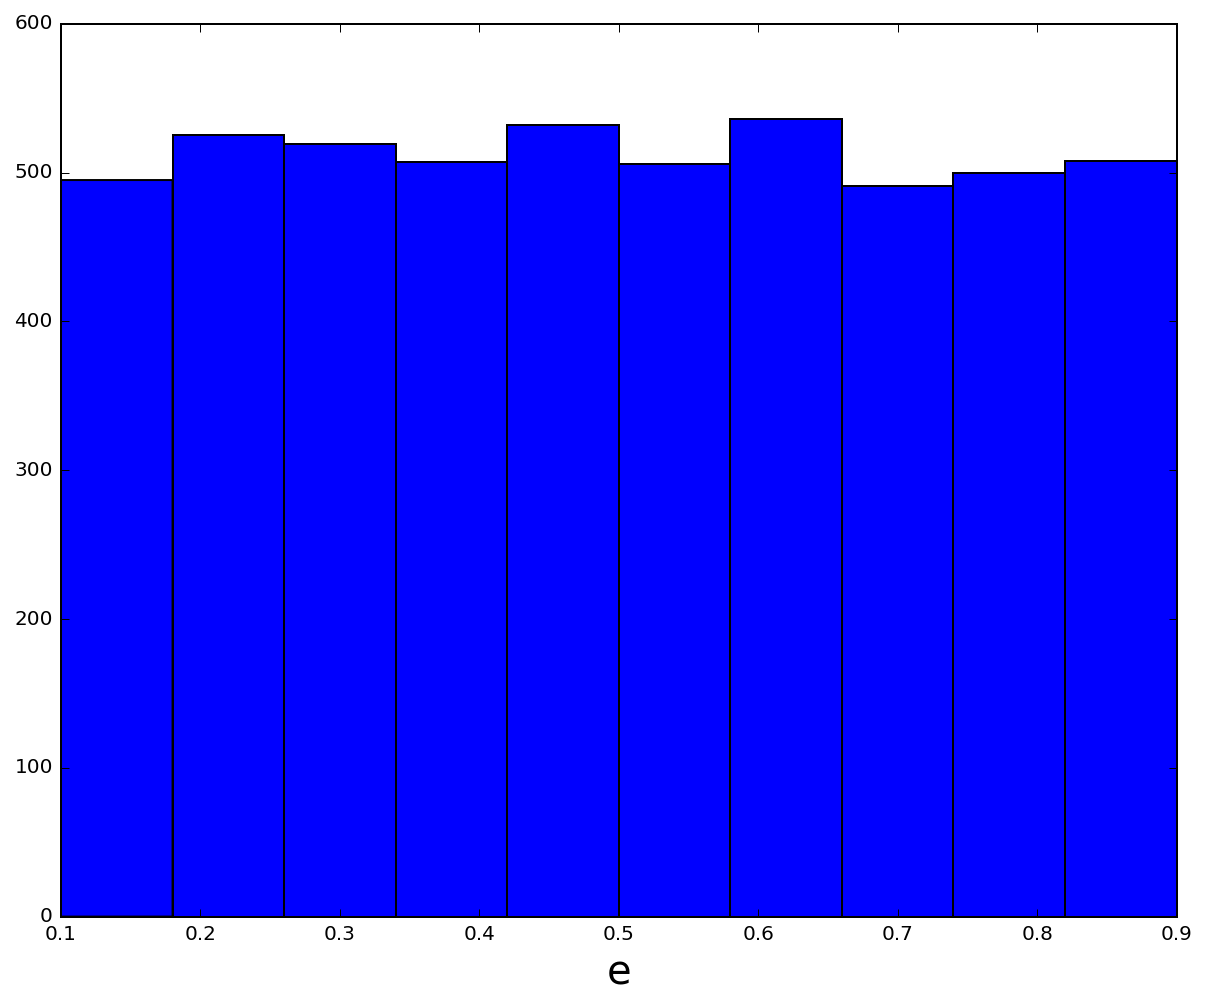

In [142]:
plt.figure(figsize=(10,8))
plt.hist(e0_choice,bins=10)
plt.xlabel(r'e',fontsize=20)
plt.show()

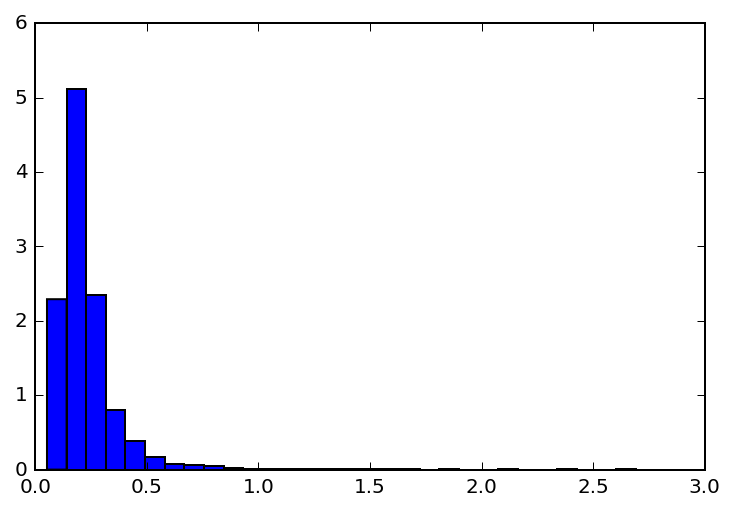

In [165]:
counts,bins,patches = plt.hist(z_loop[p_i_vec!=0],bins=30,normed=True)

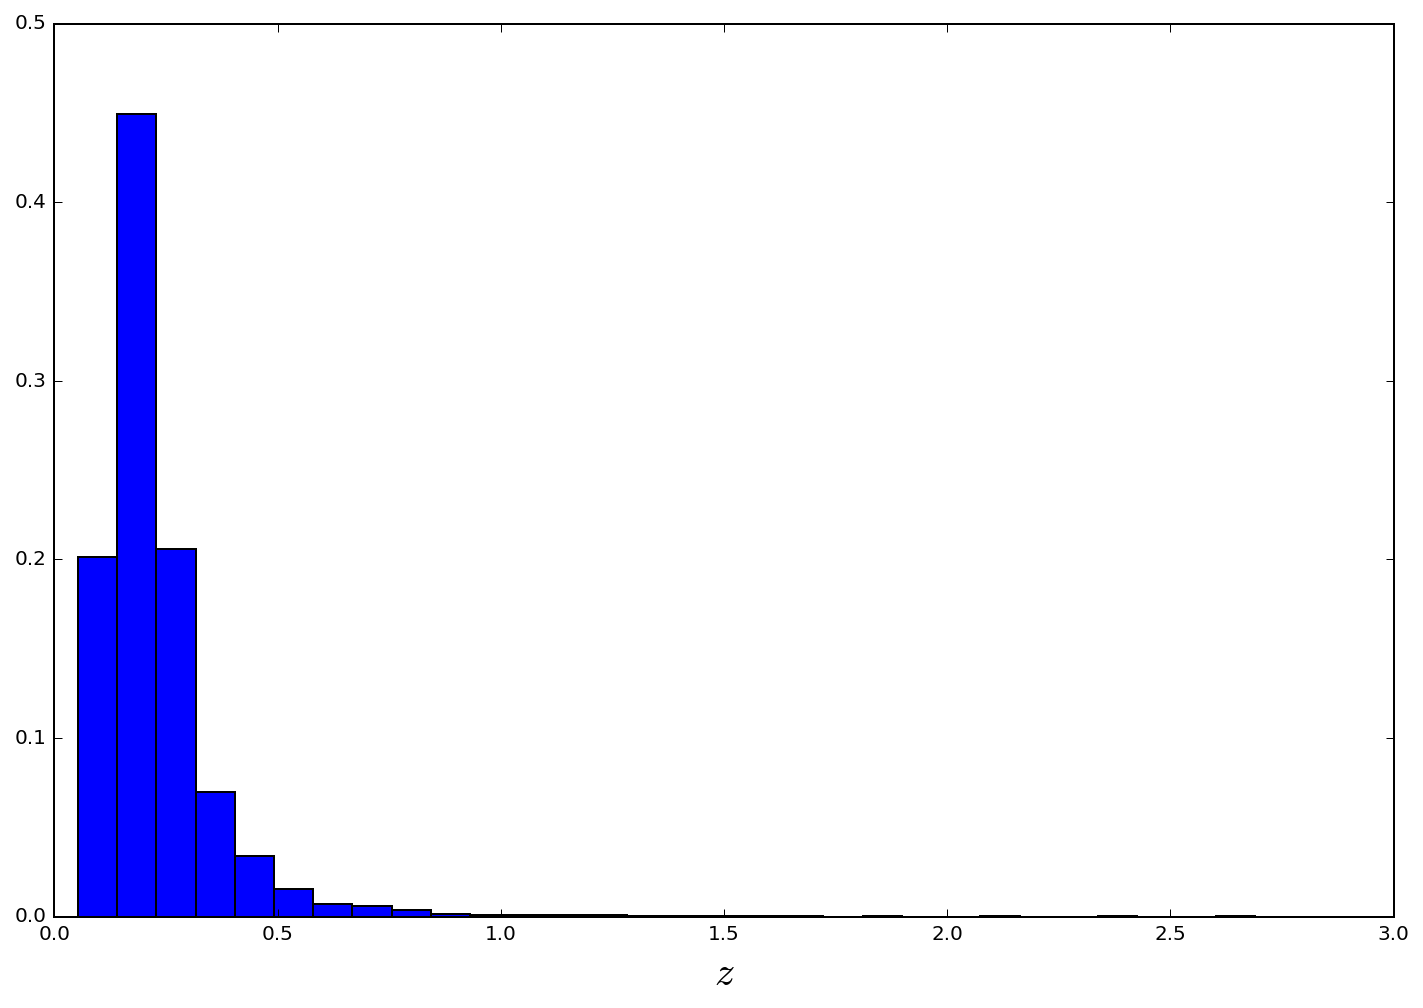

In [177]:
plt.figure(figsize=(12,8))
plt.bar(bins[0:-1],counts*(bins[1]-bins[0]),width=(bins[1:]-bins[0:-1]))
plt.xlabel(r'$z$',fontsize=20)
plt.ylim(0,0.5)
plt.show()

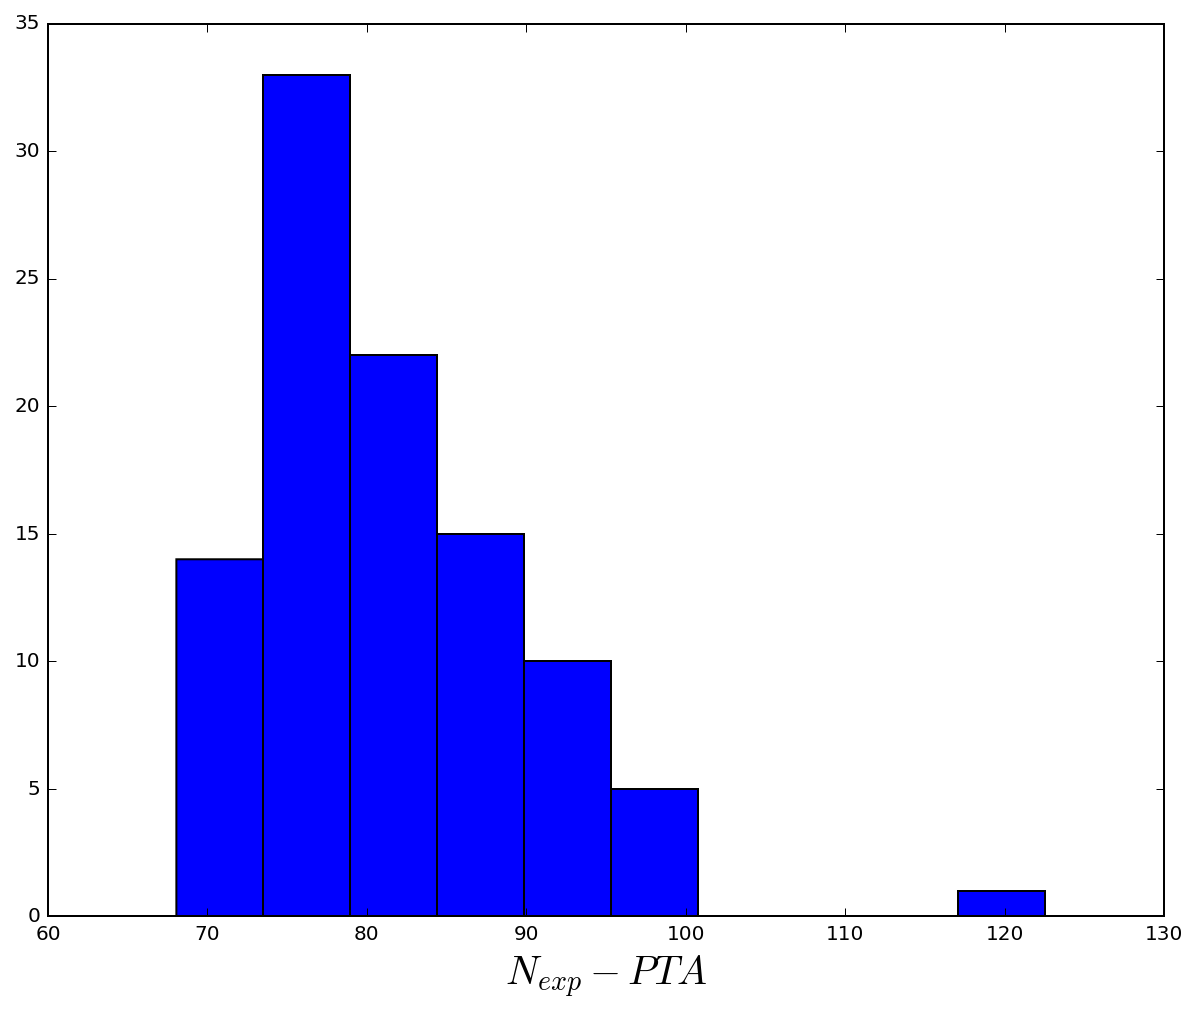

In [182]:
plt.figure(figsize=(10,8))
plt.hist(tot_gal_counter,bins=10)
plt.xlabel(r'$N_{exp} - PTA$',fontsize=20)
plt.show()

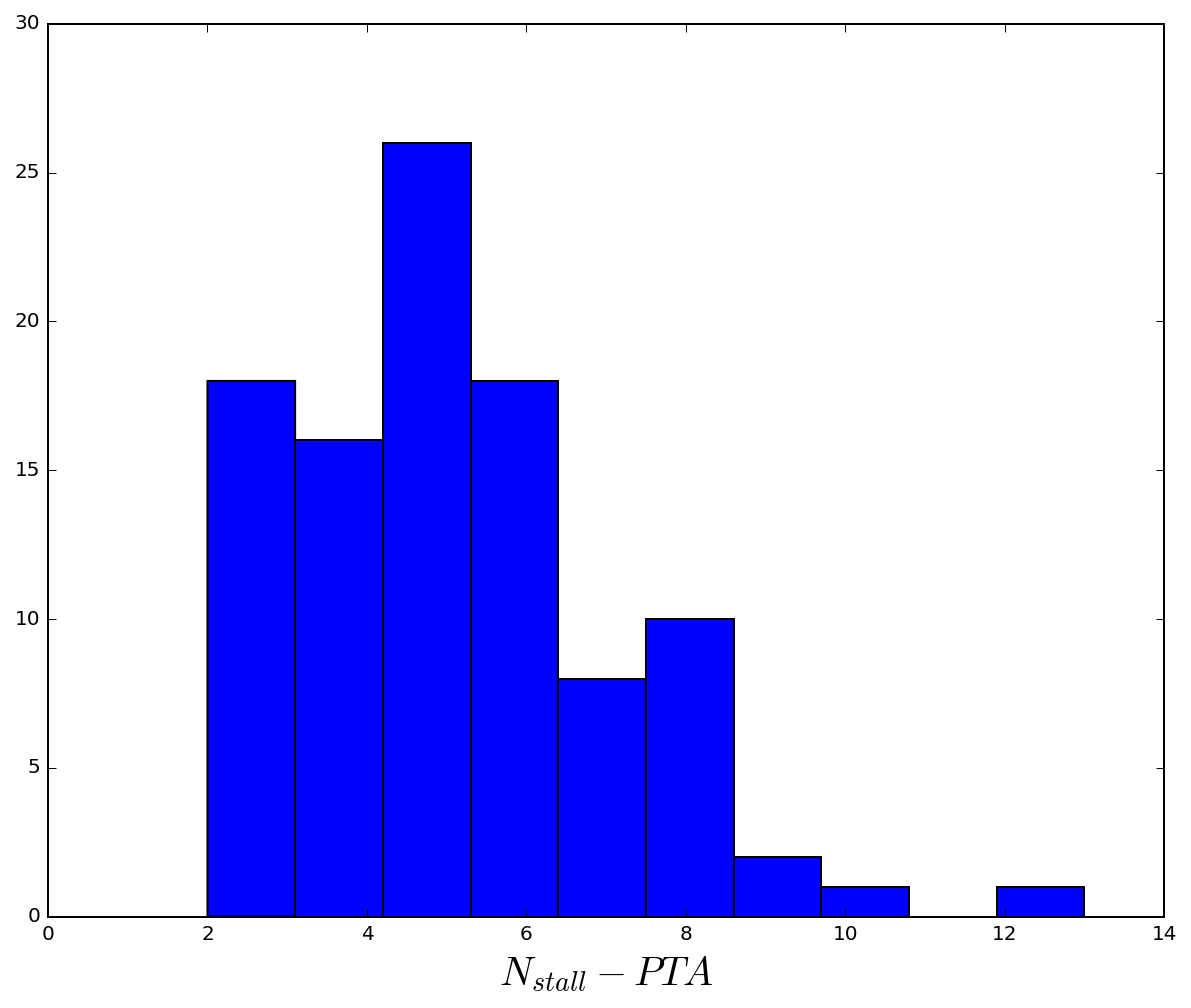

In [180]:
plt.figure(figsize=(10,8))
plt.hist(tot_stall_counter,bins=10)
plt.xlabel(r'$N_{stall} - PTA$',fontsize=20)
plt.show()

In [ ]:
# Helpful hint: if you want to count the number of realizations in your directory, do
# >> ls -l | grep -v ^l | wc -l